In [13]:
import pandas as pd
import datetime
import sys, os
import itertools
import time
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
cfg = fin_utilities.__cfg_reading("pred")
import my_functions
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense,BatchNormalization
from keras.layers import Dropout, Activation
from keras import regularizers, initializers
from sklearn.preprocessing import MinMaxScaler
from keras.layers import TimeDistributed


import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR     = eval(cfg['PROJECT_PATH'])
DATA_PATH       = PROJECT_DIR / cfg['DATA_FOLDER']
DATASET_FOLDER  = PROJECT_DIR / cfg['DATASET_FOLDER']
SOURCE          = cfg['API_DATA_SOURCE']
URL             = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS         = cfg[SOURCE]['COLUMN_NAMES']
PARAMS          = cfg[SOURCE]['REQ_PARAMS']
MAX_LENGTH      = cfg['MAX_TRADE_DURATION']
XGB_PARAM       = cfg['xgb']
TRAIN_FILE      = cfg['TRAIN_FILE']
VALIDATION_FILE = cfg['VALIDATION_FILE']
TEST_FILE       = cfg['TEST_FILE']

In [35]:
#READ TRAIN AND VAL
df_train = pd.read_csv(DATASET_FOLDER/TRAIN_FILE) 
df_val = pd.read_csv(DATASET_FOLDER/VALIDATION_FILE) 
df_test = pd.read_csv(DATASET_FOLDER/TEST_FILE) 


#Droppo i volumi visto che non sono sempre valorizzati
#df_train = df_train.drop(columns='Volume')
#df_val = df_val.drop(columns='Volume')
#df_test = df_test.drop(columns='Volume')

In [36]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [49]:
#df_train['dummy_year'] = pd.to_datetime(df_train['Time']).dt.year
#df_train['dummy_month'] = pd.to_datetime(df_train['Time']).dt.month
#df_train['dummy_day'] = pd.to_datetime(df_train['Time']).dt.day
#df_train['dummy_hour'] = pd.to_datetime(df_train['Time']).dt.hour
#df_train['dummy_dow'] = pd.to_datetime(df_train['Time']).dt.day_of_week
#df_val['dummy_year'] = pd.to_datetime(df_val['Time']).dt.year
#df_val['dummy_month'] = pd.to_datetime(df_val['Time']).dt.month
#df_val['dummy_day'] = pd.to_datetime(df_val['Time']).dt.day
#df_val['dummy_hour'] = pd.to_datetime(df_val['Time']).dt.hour
#df_val['dummy_dow'] = pd.to_datetime(df_val['Time']).dt.day_of_week

tmp = df_train['signal']
df_train = df_train.drop(columns='signal')
df_train['signal'] = tmp
tmp = df_val['signal']
df_val = df_val.drop(columns='signal')
df_val['signal'] = tmp
tmp = df_test['signal']
df_test = df_test.drop(columns='signal')
df_test['signal'] = tmp


print(df_train.shape, df_val.shape)

(10435, 23) (2880, 23)


In [53]:
to_be_dropped = [
       'Close_lag_13d', 'SMA_Close_13d', 'STD_Close_13d',
       'VAR_Close_lag_13d', 'diff_Close_13d', 'Close_lag_30d', 'SMA_Close_30d',
       'STD_Close_30d', 'VAR_Close_lag_30d', 'diff_Close_30d', 
       'Close_lag_99d',
       'SMA_Close_99d', 'STD_Close_99d', 'VAR_Close_lag_99d', 'diff_Close_99d',
       'Close_lag_200d', 'SMA_Close_200d', 'STD_Close_200d',
       'VAR_Close_lag_200d', 'diff_Close_200d'
       ]
df_train = df_train.drop(columns=to_be_dropped, errors='ignore')
df_val = df_val.drop(columns=to_be_dropped, errors='ignore')
df_test = df_test.drop(columns=to_be_dropped, errors='ignore')

In [54]:
X_train, Y_train = my_functions.split_target_features(df_train, ['Time','signal'], 'signal' )
X_val, Y_val = my_functions.split_target_features(df_val, ['Time','signal'], 'signal' )
X_test, Y_test = my_functions.split_target_features(df_test, ['Time','signal'], 'signal' )

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(10435, 11) (10435,)
(2880, 11) (2880,)


In [55]:
df_train

,Time,Open,High,Low,Close,Open_pct,High_pct,Low_pct,Close_pct,cons_green_candles,rolling_count,AVG_Candle_Price,signal
0,2021-09-05 19:00:00,-125.460938,330.175781,-141.585938,192.558594,-295.639,79.474,-1009.561,12.870,1,13.0,63.921875,0
1,2021-09-05 20:00:00,-298.753906,655.589844,-334.082031,655.589844,138.125,98.558,135.957,240.463,2,13.0,169.585938,0
2,2021-09-05 21:00:00,-948.781250,-808.273438,-1100.343750,-891.859375,217.580,-223.289,229.363,-236.039,3,13.0,-937.314453,0
3,2021-09-05 22:00:00,-33.011719,125.207031,-133.078125,125.207031,-96.521,-115.491,-87.906,-114.039,4,13.0,21.081055,0
4,2021-09-05 23:00:00,-224.535156,-192.218750,-437.347656,-294.281250,580.168,-253.521,228.640,-335.036,0,13.0,-287.095703,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10430,2022-11-17 07:00:00,-3.634766,38.365234,-10.558594,38.365234,-93.270,-600.331,-81.701,-174.066,2,9.0,15.634277,0
10431,2022-11-17 08:00:00,-34.210938,-17.177734,-62.146484,-60.636719,841.214,-144.774,488.587,-258.051,0,9.0,-43.542969,0
10432,2022-11-17 09:00:00,20.037109,20.748047,-52.923828,-37.609375,-158.569,-220.785,-14.840,-37.976,0,9.0,-12.437012,0
10433,2022-11-17 10:00:00,59.730469,82.380859,47.523438,72.515625,198.099,297.054,-189.796,-292.813,0,10.0,65.537598,0


In [58]:
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'eta':.01,
    'scale_pos_weight': 5,
    'max_depth':3,
    'objective':'binary:logistic',
    'n_estimators':3000
    }

model = my_functions.model_selection('xgb',p)

print(model.get_params())

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_val, Y_val)], verbose=100)
predictions = model.predict_proba(X_train)[:,1]
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_train, predictions)
print("Training set score: {:.5f}".format(sklearn.metrics.auc(fpr_test, tpr_test)))
predictions = model.predict_proba(X_val)[:,1]
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_val, predictions)
print("Validation set score: {:.5f}".format(sklearn.metrics.auc(fpr_test, tpr_test)))
predictions = model.predict_proba(X_val)[:,1]
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_test, predictions)
print("Test set score: {:.5f}".format(sklearn.metrics.auc(fpr_test, tpr_test)))

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 3000, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 5, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'eta': 0.01}
[0]	validation_0-auc:0.58487	validation_1-auc:0.62756


[100]	validation_0-auc:0.61283	validation_1-auc:0.62907
[200]	validation_0-auc:0.62340	validation_1-auc:0.62582
[300]	validation_0-auc:0.63251	validation_1-auc:0.62999
[400]	validation_0-auc:0.64277	validation_1-auc:0.63616
[500]	validation_0-auc:0.65101	validation_1-auc:0.63766
[600]	validation_0-auc:0.65913	validation_1-auc:0.64084
[700]	validation_0-auc:0.66640	validation_1-auc:0.64075
[800]	validation_0-auc:0.67361	validation_1-auc:0.64130
[900]	validation_0-auc:0.68004	validation_1-auc:0.64097
[1000]	validation_0-auc:0.68578	validation_1-auc:0.64085
[1100]	validation_0-auc:0.69157	validation_1-auc:0.64154
[1200]	validation_0-auc:0.69775	validation_1-auc:0.64322
[1300]	validation_0-auc:0.70330	validation_1-auc:0.64364
[1400]	validation_0-auc:0.70831	validation_1-auc:0.64383
[1500]	validation_0-auc:0.71410	validation_1-auc:0.64657
[1600]	validation_0-auc:0.71930	validation_1-auc:0.64767
[1700]	validation_0-auc:0.72465	validation_1-auc:0.64689
[1800]	validation_0-auc:0.72995	validati

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from torch.utils.data import Dataset

import numpy as np


class TabularDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y


class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, num_classes):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(input_dim, 256)  # Adjust embedding dimension to 256
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(256, num_heads, hidden_dim, dropout=0.1),
            num_layers
        )
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Reshape for transformer input
        x = self.transformer(x)
        x = x.mean(dim=0)  # Average across sequence dimension
        x = self.fc(x)
        return x

# Create a sample tabular dataset
data, targets = make_classification(n_samples=11113, n_features=26, n_informative=10, n_classes=2)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create DataLoader for training and testing
train_dataset = TabularDataset(X_train, y_train)
test_dataset = TabularDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Define the model parameters
input_dim = 26
num_heads = 8
embed_dim = 256
hidden_dim = 512
num_layers = 4
num_classes = 2

# Create the model
model = TransformerModel(input_dim, num_heads,  hidden_dim, num_layers, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Calculate the average training loss for the epoch
    train_loss /= len(train_dataset)
    
    # Evaluate on the test set


NameError: name '_C' is not defined

TIME SERIES CV

In [76]:
train = pd.concat([df_train, df_val], ignore_index=True)
tscv = TimeSeriesSplit(n_splits=10, test_size=720)

p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'max_depth':5,
    'objective':'binary:logistic',
    #'subsample': .95,
    'colsample_bytree': .9,
    'min_child_weight':1,
    'eta':0.05,
    'n_estimators':2000
}

p = {
    'tree_method':'hist',
    'objective': 'binary:logistic',   # For binary classification problems
    'eval_metric': 'auc',            # Evaluation metric (AUC in this case)
    'max_depth': 3,                  # Limit the depth of individual trees
    'min_child_weight': 1,           # Minimum sum of instance weight in a child
    'gamma': 2,                      # Minimum loss reduction required to split a leaf node
    'subsample': 0.8,                # Fraction of observations to be randomly sampled for each tree
    'colsample_bytree': 0.8,         # Fraction of features to be randomly sampled for each tree
    #'lambda': 1,                     # L2 regularization term on weights
    #'alpha': 1,                      # L1 regularization term on weights
    'learning_rate': 0.5,            # Step size shrinkage to prevent overfitting
    'n_estimators': 3000,             # Number of boosting rounds (trees) to build
    'scale_pos_weight': 2,           # Control the balance of positive and negative weights
    'seed': 42                       # Random seed for reproducibility
}

model = my_functions.model_selection('xgb',p)


for train_index, test_index in tscv.split(train):
    print(f'Train index:{train_index[0]}:{train_index[-1]}, Val index:{test_index[0]}:{test_index[-1]}')
    train_features, train_labels    = my_functions.split_target_features(train.loc[train_index], ['Time','signal'],cfg['TARGET_VARIABLE'])
    val_features, val_labels        = my_functions.split_target_features(train.loc[test_index],['Time','signal'],cfg['TARGET_VARIABLE'])
    X_train, X_test = train_features, val_features
    y_train, y_test = train_labels, val_labels
   
    
    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=500)
    

Train index:0:6808, Val index:6809:7528
[0]	validation_0-auc:0.55953	validation_1-auc:0.49854
[500]	validation_0-auc:0.98742	validation_1-auc:0.48910
[1000]	validation_0-auc:0.99444	validation_1-auc:0.48982
[1500]	validation_0-auc:0.99630	validation_1-auc:0.49860
[2000]	validation_0-auc:0.99697	validation_1-auc:0.50142
[2500]	validation_0-auc:0.99745	validation_1-auc:0.50358
[2999]	validation_0-auc:0.99757	validation_1-auc:0.50446
Train index:0:7528, Val index:7529:8248
[0]	validation_0-auc:0.54685	validation_1-auc:0.49065
[500]	validation_0-auc:0.98860	validation_1-auc:0.47615
[1000]	validation_0-auc:0.99417	validation_1-auc:0.47944
[1500]	validation_0-auc:0.99624	validation_1-auc:0.47939
[2000]	validation_0-auc:0.99702	validation_1-auc:0.47624
[2500]	validation_0-auc:0.99778	validation_1-auc:0.47732
[2999]	validation_0-auc:0.99774	validation_1-auc:0.47823
Train index:0:8248, Val index:8249:8968
[0]	validation_0-auc:0.54663	validation_1-auc:0.46897
[500]	validation_0-auc:0.98548	valid

BUILD LSTM

In [25]:
from keras.callbacks import EarlyStopping

from keras.layers.core import Dense, Dropout
from keras.optimizers import Adagrad


opt = tf.keras.optimizers.experimental.SGD(learning_rate=.2, weight_decay=0)


model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1],1)))#, kernel_initializer=initializers.RandomNormal(stddev=0.1)))
model.add(LSTM(50, return_sequences=False, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
            optimizer=opt,
            loss=['binary_crossentropy'], 
            metrics=['AUC','accuracy']
)


#early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, Y_train, batch_size=1, epochs=1000, validation_split=0.2, shuffle=False) #sample_weight_mode="temporal", sample)


# list all data in history
print(history.history.keys())
# summarize history for accuracy    
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Epoch 1/1000
10786/10791 [============================>.] - ETA: 0s - loss: 0.4202 - auc: 0.8182 - accuracy: 0.8132

ValueError: Data cardinality is ambiguous:
  x sizes: 2698
  y sizes: 538
Make sure all arrays contain the same number of samples.

In [17]:
y_pr = model.predict(X_train)
y_pr


505/505 [==============================] - 4s 6ms/step


array([[1.3968359e-07],
       [2.5722708e-04],
       [3.6357058e-05],
       ...,
       [1.0920076e-02],
       [9.7625101e-01],
       [3.9096796e-03]], dtype=float32)

In [32]:
model2 = Sequential()
model2.add(LSTM(units=512, kernel_initializer='random_normal', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.3))
model2.add(LSTM(256))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'AUC'])
model2.summary()

# Fit the model to the data
history = model2.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 22, 512)           1052672   
                                                                 
 dropout_8 (Dropout)         (None, 22, 512)           0         
                                                                 
 lstm_13 (LSTM)              (None, 256)               787456    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,906,177
Trainable params: 1,906,177
No

In [ ]:
model3 = Sequential()
model3.add(LSTM(1025, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model3.add(LSTM(256, return_sequences=True))
model3.add(LSTM(128, return_sequences=False))   
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

In [ ]:
model.fit(X_train, Y_train, epochs=10)

In [44]:
import numpy as np

# Assume your DataFrame is called df

# Step 1: Convert DataFrame to a numpy array
data = X_train
print(np.shape(X_train))
# Step 2: Define the window size, i.e., the number of time steps to look back
window_size = 24

# Step 3: Create empty lists to hold the inputs and outputs
X_train = []
Y_train = np.array(Y_train[window_size:])

# Step 4: Loop through the data and create the inputs and outputs
for i in range(window_size, len(data)):
    X_train.append(data[i-window_size:i])
#    y.append(data[len(features)-1][0])  # use the close price as the output variable

# Step 5: Convert the lists to numpy arrays
X_train = np.array(X_train)

# Step 6: Reshape the input data into a 3D tensor
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
#X_train = np.transpose(X_train, (0, 2,1))


#X_test = data[-(TEST_SIZE+window_size): , : ]
X_test = []
Y_test = np.array(Y_test)

# Step 4: Loop through the data and create the inputs and outputs
for i in range(len(data)-TEST_SIZE, len(data)):
    X_test.append(data[i-window_size:i])

X_test = np.array(X_test)
#X_test = np.transpose(X_test, (0, 2,1))

print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_test), np.shape(Y_test))



(16139, 22)
(16115, 24, 22) (16115,)
(720, 24, 22) (720,)


In [47]:


#model = Sequential()
#model.add(LSTM(50, return_sequences=True, kernel_regularizer=regularizers.l2(0.01),  kernel_initializer=initializers.RandomNormal(stddev=0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(200, return_sequences=False))
#model.add(Dense(25))
#model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.experimental.SGD(learning_rate=.2)

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

#model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='mse', optimizer=opt)

model.summary()

model.compile(optimizer=opt, loss=['binary_crossentropy'], metrics=['AUC','accuracy'])
history = model.fit(X_train, Y_train, batch_size=10, epochs=100, validation_batch_size=0.2, shuffle=False)


"""import tensorflow as tf

model = Sequential()
model.add(Bidirectional(
    LSTM(500, input_shape=(X_train.shape[1], X_train.shape[2]))
    )
)
model.add(LSTM(200, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.experimental.Adam(
    learning_rate=0.02), loss='mean_squared_error', metrics=['accuracy'])


model.fit(X_train, Y_train, batch_size= 30, epochs=50, shuffle=False)"""

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 20)            3440      
                                                                 
 lstm_9 (LSTM)               (None, 24, 50)            14200     
                                                                 
 lstm_10 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 37,891
Trainable params: 37,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1612/1612 [==============================] - 44s 24ms/step - loss: 0.6929 - auc: 0.5024 - accuracy: 0.5216
Epoch 2/100
1612/1612 [==============================] - 40s 25

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


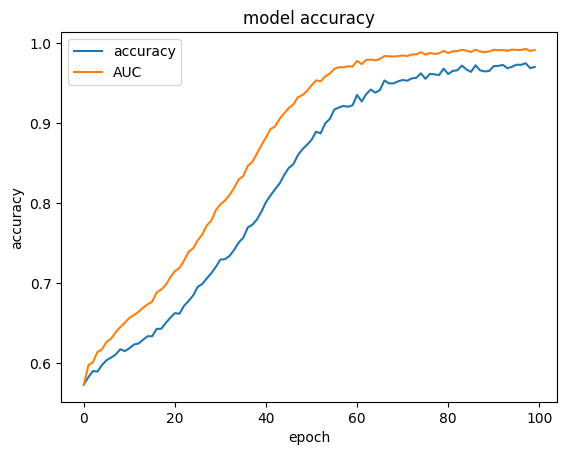

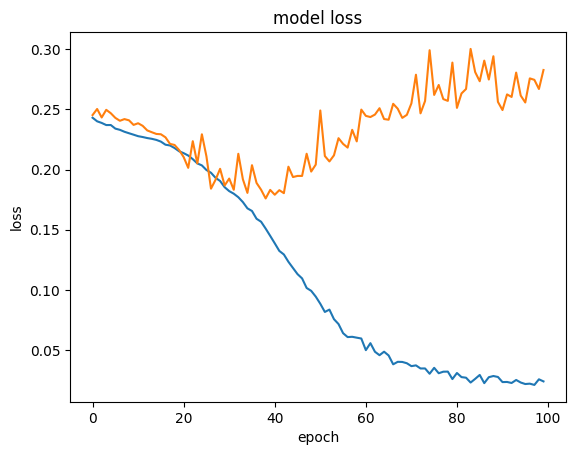

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy    
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'AUC'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
y_pr = model.predict(X_train)
y_pr

523/523 [==============================] - 7s 12ms/step


array([[0.46137884],
       [0.46136647],
       [0.46137354],
       ...,
       [0.46133852],
       [0.4612569 ],
       [0.46121606]], dtype=float32)

In [20]:
predictions = model.predict(X_test)
predictions = predictions[:,0]
predictions

23/23 [==============================] - 0s 8ms/step


array([4.62367535e-01, 2.40527660e-01, 8.22766066e-01, 9.36416669e-08,
       9.91647780e-01, 9.01434839e-01, 5.87249128e-03, 9.93281782e-01,
       5.78955514e-05, 9.93261099e-01, 9.93328452e-01, 8.18697501e-08,
       2.29652971e-02, 9.99999046e-01, 1.94596425e-01, 4.07232146e-04,
       9.97310102e-01, 1.68252771e-03, 9.99998808e-01, 9.87162232e-01,
       5.70634723e-01, 9.99974310e-01, 9.99227941e-01, 1.43323913e-01,
       3.86165222e-03, 9.38225925e-01, 5.20641565e-01, 1.65166017e-02,
       9.94368196e-01, 7.79206725e-03, 2.33892217e-01, 9.99992847e-01,
       9.99997377e-01, 1.17584341e-03, 3.58278930e-01, 7.12839095e-03,
       9.62902069e-01, 9.99999881e-01, 9.94640052e-01, 2.44185612e-01,
       6.82145417e-01, 2.75184284e-03, 9.99998391e-01, 1.49769783e-01,
       9.99608159e-01, 1.09477165e-04, 4.85749661e-06, 7.25006757e-05,
       8.96796167e-01, 7.09646894e-03, 2.71033078e-01, 5.15928134e-10,
       2.48569238e-04, 6.57115877e-02, 3.11642289e-01, 6.64973021e-01,
      

In [21]:
#predictions = (predictions-np.min(predictions))/(np.max(predictions)-np.min(predictions))

In [22]:
#my_functions.plt_correlation(train)

In [23]:
from sklearn.metrics import fbeta_score

best_precision = 0
thresh = 0
for i in np.arange(0.01, 1, 0.01):
    y_pred = [1 if el > i else 0 for el in predictions]
    #precision = sklearn.metrics.accuracy_score(Y_test, y_pred) # average='weighted', beta=.5)
    precision = sklearn.metrics.fbeta_score(Y_test, y_pred, average='weighted', beta=.5)
    if best_precision < precision:
        thresh = i 
        best_precision = precision

print(best_precision)
print(thresh)

0.5939001407580107
0.77


In [24]:
y_pred = [1 if el>thresh else 0 for el in predictions]

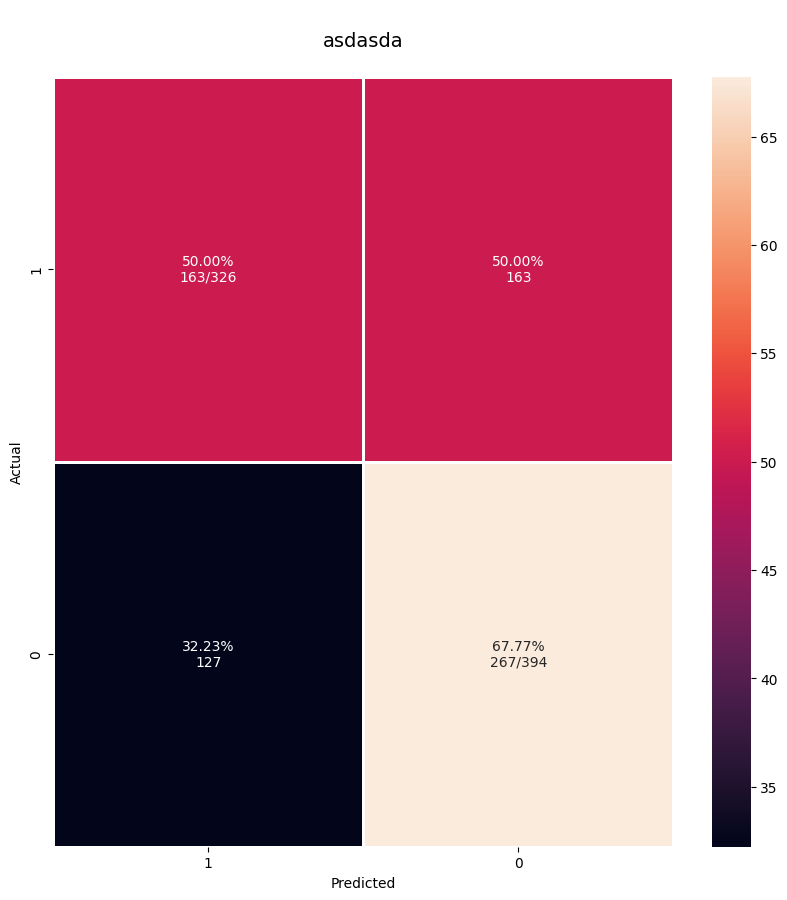

In [25]:
from sklearn.metrics import confusion_matrix

def cm_analysis(
    y_true, 
    y_pred, 
    title: str,
    filename: str, 
    labels: List[str], 
    ymap=None, 
    figsize=(10,10)
) -> None:
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.

    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      title:     plot name
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.

    Returns:
        None
    """

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', linewidths=1, ax=ax)
    plt.title('\n'+title+'\n', fontsize=14)
    plt.show()


cm_analysis(Y_test, y_pred,title='asdasda',filename='cm.png',labels=[1,0])

In [43]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_test, predictions)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
print(auc_test)
#skplt.metrics.plot_roc(df_test['signal'],y_probas, title=f"ROC curve, AUC=test: {auc_test:.4f}", classes_to_plot=[1], figsize=(10,10))
#plt.show()

0.5302116786067194


In [ ]:
df.head()

In [ ]:
close_prices = df['price_close']
values = close_prices.values
training_data_len = int(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]



x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

print(np.shape(x_train), np.shape(y_train))

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
print(np.shape(x_train), np.shape(y_train))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(np.shape(x_test), np.shape(y_test))

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

In [ ]:
data = df.filter(['price_close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price_close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
import numpy as np

# Assume your DataFrame is called df

# Step 1: Convert DataFrame to a numpy array
data = np.array(df[features])

# Step 2: Define the window size, i.e., the number of time steps to look back
window_size = 50

# Step 3: Create empty lists to hold the inputs and outputs
X = []
y = df['signal'][window_size:]

# Step 4: Loop through the data and create the inputs and outputs
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
#    y.append(data[len(features)-1][0])  # use the close price as the output variable

# Step 5: Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Step 6: Reshape the input data into a 3D tensor
X = np.reshape(X, (X.shape[0], X.shape[1], len(features)))
X2 = np.transpose(X, (0, 2,1))
print(np.shape(X), np.shape(y))
print(np.shape(X2))




In [ ]:
y

In [ ]:
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adagrad


model = Sequential()
model.add(LSTM(200, return_sequences=True, activation='relu', input_shape=(X2.shape[1],X2.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop',    
              metrics=['accuracy']
            )

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X2, y, batch_size= 1, epochs=3)

In [ ]:
y_test = model.predict(X2)

In [ ]:
y_test